# Facial Expression Recognition 

# WorkFlow/ Approach steps 

---Algorithm approach------- 

1.Loading of the FER data
2.Displaying the loaded data 
3.Displaying one unique emotion 
4.Data distribution of FER data
5.Image Augmentation for FER date like(rotation,blur, flip,salt peper noise)
6.Convert Image pixel to a dataframe 
7.Equalize the data distribution over all the emotion data 
8.Build a FER network architecture using Winograd Convolution

---Performance Validation-------

9.Performance Evaluation(PE):Plotting the predicted probablites
10.PE:Prediction vs True prediction 
11.PE:Confusion Matrix 
12.PE:Classification Matrix
13.Vizualization of a layer 

--- Analysis and Next steps---- 

14.Detailed Analysis 
15.Future Scope
16.Result comparison with state of the art (Kaggle)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import random

matplotlib.style.use('ggplot')
%matplotlib inline

# Loading of FER data

In [2]:
df = pd.read_csv("./fer2013.csv")
print(df.head())
print("Number of unique Emotions: %s" % (df.emotion.unique()))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Number of unique Emotions: [0 2 4 6 3 5 1]


This displays the first few rows of the FER data read from the csv containing emotions ,pixels and usage column 

# Helper Functions

In [3]:
# pixels is the series from the Dataframe
def extract_from_string(pixels):
    pixels = pixels.split(' ')
    pixels = np.array([int(i) for i in pixels])
    return np.reshape(pixels, (48, 48))    

def extract_image(pixels):
    pixels = pixels.as_matrix()[0] # The output is a string
    return extract_from_string(pixels)

# Display of loaded Image

In [4]:
def overview(total_rows, df):
    fig = plt.figure(figsize=(8,10))
    idx = 0
    for i, row in df.iterrows():
        input_img = extract_from_string(row.pixels)
        ax = fig.add_subplot(16,12,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
    plt.show()

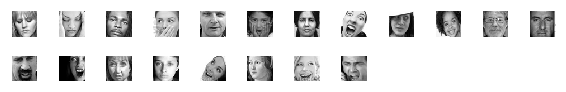

In [5]:
num_images = 20
df = df.sample(n=num_images)
overview(num_images, df) # overview of face data as thumbnails (private)

This shows the plot of few 20 images from the data read and converted to the images 

# Displaying one Unique Emotion

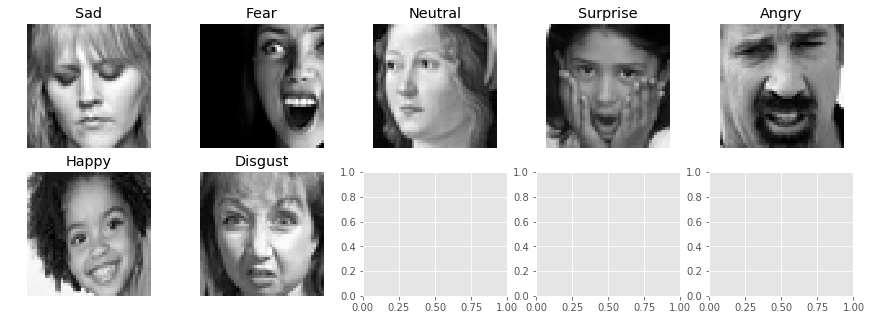

In [6]:
emotion_description = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

unique_emotions = df.emotion.unique()
images = []
emotions = []
for emotion in unique_emotions:
    emotion_df = df[df.emotion == emotion].sample(n=1)
    images.append(extract_image(emotion_df.pixels))
    emotions.append(emotion)

cols = 5
fig, ax = plt.subplots(len(images) // cols + 1, cols, figsize=(15, 5))
global_img = None
for i,img in enumerate(images):
    row = i // cols
    col = i % cols
    ax[row, col].imshow(img, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(emotion_description[emotions[i]])
    global_img = img

This shows the plots of seven different unique emotions from the FER data

# Emotion Data Distribution

0    3
1    2
2    2
3    3
4    2
5    2
6    6
Name: emotion, dtype: int64


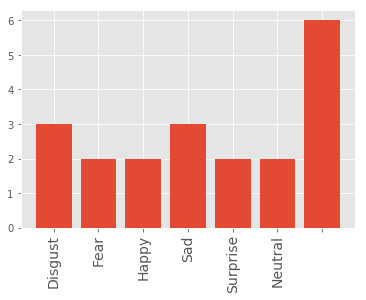

In [7]:
value_counts = df['emotion'].value_counts().sort_index()
ax = plt.subplot()
x_ticks_labels = [emotion_description[i] for i in range(len(value_counts))]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
ax.bar(range(0, len(value_counts)), value_counts)
print(value_counts)

The data distribution of the emotion dataset read from the csv

# Use Image Augmentation to Augment the dataset

In [8]:
from scipy import ndimage
from scipy.misc import imresize
from skimage import data, io, filters
from skimage.transform import swirl

import cv2

# Image Augmentation Techniques

In [9]:
def display_side_by_side(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img2, cmap='gray')
    ax[1].axis('off')    

In [10]:
def ogrid(img):
    nimg = np.copy(img)
    lx, ly = nimg.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4
    nimg[mask] = 0
    return nimg

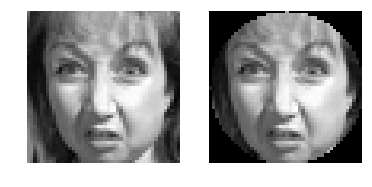

In [11]:
nimg = ogrid(global_img)
display_side_by_side(global_img, nimg)

In [12]:
def rotate_img(img):
    angle = np.random.choice(np.random.uniform(-45,45,100))
    nimg = np.copy(img)
    nimg = ndimage.rotate(nimg, angle)
    height, width = img.shape
    nimg = imresize(nimg, (width, height))
    return nimg

c:\python35\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


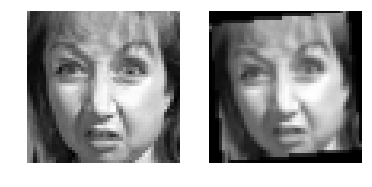

In [13]:
nimg = rotate_img(global_img)
display_side_by_side(global_img, nimg)

In [14]:
def blur_img(img):
    nimg = np.copy(img)
    sigma = np.random.randint(1, 2)
    blurred_img = ndimage.gaussian_filter(nimg, sigma=sigma)
    return blurred_img

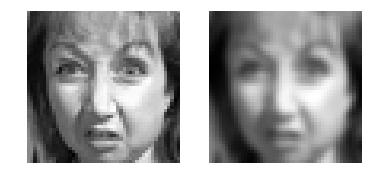

In [15]:
nimg = blur_img(global_img)
display_side_by_side(global_img, nimg)

In [16]:
def flip_img(img):
    nimg = np.copy(img)
    nimg = np.fliplr(nimg)
    return nimg

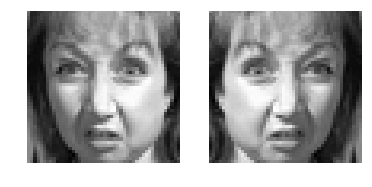

In [17]:
nimg = flip_img(global_img)
display_side_by_side(global_img, nimg)

In [18]:
def add_noise(img):
    nimg = np.copy(img)
    noise = np.random.normal(0,0.5,size=(48, 48)).astype(np.uint8) * 255
    nimg += noise
    nimg = np.clip(nimg, 0, 255)
    return nimg

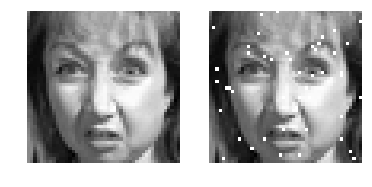

In [19]:
nimg = add_noise(global_img)
display_side_by_side(global_img, nimg)

In [20]:
def augment_img(img):
    methods = [ogrid, rotate_img, blur_img, flip_img, add_noise]

    method = np.random.choice(methods)
    return method(img)

In [21]:
max_value = df['emotion'].value_counts().max()
max_idx = df['emotion'].value_counts().idxmax()
print(max_idx, max_value)

6 6


# Convert the pixel data into dataframe for processing

In [22]:
new_df = pd.DataFrame()
for i, row in df.iterrows():
    # Take this row and convert its pixel type to actual image
    new_df = new_df.append(pd.Series([row.emotion, extract_from_string(row.pixels), row.Usage], index=['emotion', 'pixels', 'Usage'], name=str(i)))
    
print(new_df)

             Usage  emotion                                             pixels
10078     Training      4.0  [[29, 30, 62, 105, 112, 155, 134, 118, 147, 16...
30480   PublicTest      2.0  [[147, 144, 161, 113, 122, 177, 150, 113, 117,...
30210   PublicTest      6.0  [[107, 87, 71, 75, 62, 60, 63, 73, 77, 80, 67,...
18864     Training      5.0  [[255, 254, 253, 254, 252, 254, 240, 150, 107,...
16206     Training      6.0  [[55, 57, 117, 160, 156, 159, 186, 198, 191, 1...
27818     Training      5.0  [[255, 188, 34, 31, 26, 24, 24, 23, 23, 26, 27...
11317     Training      6.0  [[109, 40, 28, 30, 32, 31, 31, 28, 31, 31, 35,...
32540  PrivateTest      0.0  [[254, 254, 254, 254, 254, 254, 254, 254, 254,...
16870     Training      6.0  [[253, 254, 254, 254, 254, 254, 254, 253, 253,...
31006   PublicTest      3.0  [[223, 215, 132, 74, 72, 61, 62, 40, 43, 40, 3...
14068     Training      6.0  [[80, 72, 67, 69, 87, 80, 58, 68, 76, 82, 90, ...
10732     Training      1.0  [[74, 77, 93, 95, 108, 

# Making all the Image categories the same size

In [23]:
augmented_df = new_df.copy()
unique_emotions = new_df.emotion.unique()
for emotion in unique_emotions:
    if emotion != max_idx:
        # This is the dataset we want to augment
        # Find the current length of this emotion
        emotion_df = augmented_df[augmented_df.emotion == emotion]
        current_size = len(emotion_df)
        images_2_generate = max_value - current_size
        for i in range(0, images_2_generate):
            # Choose a random image
            emotion_df = augmented_df[augmented_df.emotion == emotion].sample(n=1)
            current_img = emotion_df.pixels[0]
            nimg = augment_img(current_img)
            
            # Add a new row
            row = pd.Series([emotion, nimg, "Training"], index=["emotion", "pixels", "Usage"], name=str(i))
            augmented_df = augmented_df.append(row)

c:\python35\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


# Equalized New Data Distribution

0.0    6
1.0    6
2.0    6
3.0    6
4.0    6
5.0    6
6.0    6
Name: emotion, dtype: int64


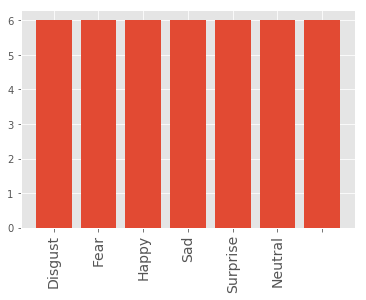

In [24]:
value_counts = augmented_df['emotion'].value_counts().sort_index()
ax = plt.subplot()
x_ticks_labels = [emotion_description[i] for i in range(len(value_counts))]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
ax.bar(range(0, len(value_counts)), value_counts)
print(value_counts)

# Network Architecture 

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Lambda, Activation,SeparableConv2D
from keras.layers import Conv2D, MaxPooling2D, concatenate, Input
from keras.callbacks import TensorBoard
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from keras.utils import np_utils

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [26]:
class FERNet:
    
    def build(width, height, depth, classes,num_filters, weightsPath=None):
        model = Sequential()
        model.add(SeparableConv2D(num_filters, kernel_size=(3, 1),input_shape=(width, height, 1), data_format='channels_last'))
        model.add(SeparableConv2D(num_filters, kernel_size=(1, 3), activation='relu'))


        model.add(BatchNormalization())
        model.add(SeparableConv2D(num_filters, kernel_size=(3, 1),  padding='same'))
        model.add(SeparableConv2D(num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))


        model.add(SeparableConv2D(2*num_filters, kernel_size=(3, 1), padding='same'))
        model.add(SeparableConv2D(2*num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(SeparableConv2D(2*num_filters, kernel_size=(3, 1), padding='same'))
        model.add(SeparableConv2D(2*num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))

        model.add(SeparableConv2D(2*2*num_filters, kernel_size=(3, 1), padding='same'))
        model.add(SeparableConv2D(2*2*num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(SeparableConv2D(2*2*num_filters, kernel_size=(3, 1), padding='same'))
        model.add(SeparableConv2D(2*2*num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.25))

        model.add(SeparableConv2D(2*2*2*num_filters, kernel_size=(3, 1),  padding='same'))
        model.add(SeparableConv2D(2*2*2*num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(SeparableConv2D(2*2*2*num_filters, kernel_size=(3, 1), padding='same'))
        model.add(SeparableConv2D(2*2*2*num_filters, kernel_size=(1, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(4*4*num_filters, activation='relu'))
        model.add(Dropout(0.45))
        model.add(Dense(4*4*num_filters, activation='relu'))
        model.add(Dropout(0.45))


        model.add(Dense(7, activation='softmax'))

        if weightsPath is not None:
            model.load_weights(weightsPath)

        return model

In [27]:
num_filters = 64
img_width=48
img_height=48
img_depth=1
num_classes=7

In [28]:
model = FERNet.build(img_width, img_height, img_depth, num_classes,num_filters)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 46, 48, 64)        131       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 46, 46, 64)        4352      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 46, 46, 64)        4352      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 46, 46, 64)        4352      
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
__________

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#using imagedata generator api from keras for further augmentation 
generator = ImageDataGenerator( featurewise_center=True,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=20.,
                            width_shift_range=0.4,
                            height_shift_range=0.4,
                            shear_range=0.2,
                            zoom_range=0.2,
                            channel_shift_range=0.1,
                            fill_mode='nearest',
                            horizontal_flip=True,
                            vertical_flip=False,
                            rescale=1.2,
                            preprocessing_function=None)

In [31]:
train_df = augmented_df[augmented_df.Usage == "Training"]
test_df = augmented_df[augmented_df.Usage == "PrivateTest"]

trainData = np.array(train_df.pixels, dtype=pd.Series)
trainLabels = np.array(train_df.emotion, dtype=pd.Series)
trainLabels = np_utils.to_categorical(trainLabels, 7)


testData = np.array(train_df.pixels, dtype=pd.Series)
testLabels = np.array(train_df.emotion, dtype=pd.Series)
testLabels = np_utils.to_categorical(testLabels, 7)

td = []
for t in trainData:
    t = np.reshape(t, (48, 48, 1))
    td.append(t)
    
tl = []
for t in trainLabels:
    tl.append(t)

trainData = np.array(td)
trainLabels = np.array(tl)

trainData, trainLabels = shuffle(trainData, trainLabels)

td = []
for t in testData:
    t = np.reshape(t, (48, 48, 1))
    td.append(t)
    
tl = []
for t in testLabels:
    tl.append(t)

testData = np.array(td)
testLabels = np.array(tl)

In [32]:
generator.fit(trainData)
filepath = "FERNet.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
batch_size = 128

#enable the flag if you want to use the image augmentation api
use_augmentation = False
if use_augmentation:
    trainData, validationData, trainLabels, validationLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=20)
    hist = model.fit_generator(generator.flow(trainData, trainLabels, batch_size=batch_size),
                          steps_per_epoch= int(len(trainData) / batch_size + 1),
                          epochs=50,
                          verbose=1,
                          validation_data=(validationData, validationLabels),
                          callbacks=[TensorBoard(log_dir='logs'), checkpoint, TQDMNotebookCallback(leave_inner=False, leave_outer=True)])
else:
    hist = model.fit(trainData, trainLabels, epochs=100, batch_size=batch_size,
              validation_split=0.1, callbacks=[TensorBoard(log_dir='logs'), checkpoint, TQDMNotebookCallback(leave_inner=False, leave_outer=True)], shuffle=True, verbose=1)

Train on 33 samples, validate on 4 samples


Epoch 1/100


33/33 [==============================] - 4s 114ms/step - loss: 1.9459 - acc: 0.1212 - val_loss: 1.9775 - val_acc: 0.2500

Epoch 00001: val_acc improved from -inf to 0.25000, saving model to FERNet.best.h5
Epoch 2/100


33/33 [==============================] - 1s 27ms/step - loss: 1.9442 - acc: 0.3333 - val_loss: 2.0459 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve
Epoch 3/100


33/33 [==============================] - 1s 27ms/step - loss: 1.9407 - acc: 0.1515 - val_loss: 2.2244 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve
Epoch 4/100


33/33 [==============================] - 1s 16ms/step - loss: 1.9330 - acc: 0.1818 - val_loss: 2.5707 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve
Epoch 5/100


33/33 [==============================] - 1s 16ms/step - loss: 1.9271 - acc: 0.2121 - val_loss: 3.0956 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve
Epoch 6/100


33/33 [==============================] - 1s 17ms/step - loss: 1.9177 - acc: 0.0909 - val_loss: 3.7927 - val_acc: 0.0000e+00

Epoch 00006: val_acc did not improve
Epoch 7/100


33/33 [==============================] - 1s 16ms/step - loss: 1.9079 - acc: 0.2121 - val_loss: 4.5298 - val_acc: 0.0000e+00

Epoch 00007: val_acc did not improve
Epoch 8/100


33/33 [==============================] - 1s 17ms/step - loss: 1.8723 - acc: 0.0909 - val_loss: 5.2927 - val_acc: 0.0000e+00

Epoch 00008: val_acc did not improve
Epoch 9/100


33/33 [==============================] - 1s 17ms/step - loss: 1.9290 - acc: 0.1515 - val_loss: 5.4539 - val_acc: 0.0000e+00

Epoch 00009: val_acc did not improve
Epoch 10/100


33/33 [==============================] - 1s 17ms/step - loss: 1.9378 - acc: 0.0909 - val_loss: 5.2074 - val_acc: 0.0000e+00

Epoch 00010: val_acc did not improve
Epoch 11/100


33/33 [==============================] - 1s 16ms/step - loss: 1.9090 - acc: 0.2424 - val_loss: 4.9060 - val_acc: 0.0000e+00

Epoch 00011: val_acc did not improve
Epoch 12/100


33/33 [==============================] - 1s 17ms/step - loss: 1.9016 - acc: 0.2727 - val_loss: 4.6290 - val_acc: 0.0000e+00

Epoch 00012: val_acc did not improve
Epoch 13/100


33/33 [==============================] - 1s 17ms/step - loss: 1.9147 - acc: 0.0909 - val_loss: 4.4341 - val_acc: 0.0000e+00

Epoch 00013: val_acc did not improve
Epoch 14/100


33/33 [==============================] - 1s 16ms/step - loss: 1.8646 - acc: 0.2121 - val_loss: 4.4249 - val_acc: 0.0000e+00

Epoch 00014: val_acc did not improve
Epoch 15/100


33/33 [==============================] - 1s 16ms/step - loss: 1.8870 - acc: 0.2121 - val_loss: 4.5571 - val_acc: 0.0000e+00

Epoch 00015: val_acc did not improve
Epoch 16/100


33/33 [==============================] - 1s 16ms/step - loss: 1.8285 - acc: 0.1818 - val_loss: 5.0578 - val_acc: 0.0000e+00

Epoch 00016: val_acc did not improve
Epoch 17/100


33/33 [==============================] - 1s 16ms/step - loss: 1.7802 - acc: 0.1818 - val_loss: 6.2074 - val_acc: 0.0000e+00

Epoch 00017: val_acc did not improve
Epoch 18/100


33/33 [==============================] - 1s 17ms/step - loss: 1.7633 - acc: 0.3030 - val_loss: 6.9842 - val_acc: 0.0000e+00

Epoch 00018: val_acc did not improve
Epoch 19/100


33/33 [==============================] - 1s 26ms/step - loss: 1.6490 - acc: 0.3030 - val_loss: 7.6075 - val_acc: 0.0000e+00

Epoch 00019: val_acc did not improve
Epoch 20/100


33/33 [==============================] - 1s 17ms/step - loss: 1.5518 - acc: 0.3939 - val_loss: 8.9508 - val_acc: 0.0000e+00

Epoch 00020: val_acc did not improve
Epoch 21/100


33/33 [==============================] - 1s 16ms/step - loss: 1.5903 - acc: 0.3030 - val_loss: 11.2457 - val_acc: 0.0000e+00

Epoch 00021: val_acc did not improve
Epoch 22/100


33/33 [==============================] - 1s 17ms/step - loss: 1.4612 - acc: 0.3939 - val_loss: 13.2272 - val_acc: 0.0000e+00

Epoch 00022: val_acc did not improve
Epoch 23/100


33/33 [==============================] - 1s 17ms/step - loss: 1.4272 - acc: 0.3333 - val_loss: 14.2724 - val_acc: 0.0000e+00

Epoch 00023: val_acc did not improve
Epoch 24/100


33/33 [==============================] - 1s 17ms/step - loss: 1.2416 - acc: 0.5758 - val_loss: 14.9888 - val_acc: 0.0000e+00

Epoch 00024: val_acc did not improve
Epoch 25/100


33/33 [==============================] - 1s 24ms/step - loss: 1.1849 - acc: 0.5758 - val_loss: 15.9282 - val_acc: 0.0000e+00

Epoch 00025: val_acc did not improve
Epoch 26/100


33/33 [==============================] - 1s 16ms/step - loss: 0.9481 - acc: 0.6364 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00026: val_acc did not improve
Epoch 27/100


33/33 [==============================] - 1s 27ms/step - loss: 1.0457 - acc: 0.6061 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00027: val_acc did not improve
Epoch 28/100


33/33 [==============================] - 1s 17ms/step - loss: 0.8280 - acc: 0.6667 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00028: val_acc did not improve
Epoch 29/100


33/33 [==============================] - 1s 16ms/step - loss: 0.8886 - acc: 0.6364 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00029: val_acc did not improve
Epoch 30/100


33/33 [==============================] - 1s 16ms/step - loss: 0.6031 - acc: 0.8182 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00030: val_acc did not improve
Epoch 31/100


33/33 [==============================] - 1s 16ms/step - loss: 0.9823 - acc: 0.7879 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00031: val_acc did not improve
Epoch 32/100


33/33 [==============================] - 1s 16ms/step - loss: 0.6960 - acc: 0.7576 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00032: val_acc did not improve
Epoch 33/100


33/33 [==============================] - 1s 16ms/step - loss: 0.5700 - acc: 0.8788 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00033: val_acc did not improve
Epoch 34/100


33/33 [==============================] - 1s 16ms/step - loss: 0.4588 - acc: 0.8485 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00034: val_acc did not improve
Epoch 35/100


33/33 [==============================] - 1s 16ms/step - loss: 0.5062 - acc: 0.8182 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00035: val_acc did not improve
Epoch 36/100


33/33 [==============================] - 1s 16ms/step - loss: 0.4914 - acc: 0.8485 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00036: val_acc did not improve
Epoch 37/100


33/33 [==============================] - 1s 16ms/step - loss: 0.2716 - acc: 0.8788 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00037: val_acc did not improve
Epoch 38/100


33/33 [==============================] - 1s 16ms/step - loss: 0.1909 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00038: val_acc did not improve
Epoch 39/100


33/33 [==============================] - 1s 16ms/step - loss: 0.2695 - acc: 0.9091 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00039: val_acc did not improve
Epoch 40/100


33/33 [==============================] - 1s 16ms/step - loss: 0.2196 - acc: 0.9091 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00040: val_acc did not improve
Epoch 41/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1872 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00041: val_acc did not improve
Epoch 42/100


33/33 [==============================] - 1s 16ms/step - loss: 0.1218 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00042: val_acc did not improve
Epoch 43/100


33/33 [==============================] - 1s 16ms/step - loss: 0.3300 - acc: 0.9091 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00043: val_acc did not improve
Epoch 44/100


33/33 [==============================] - 1s 16ms/step - loss: 0.2184 - acc: 0.8788 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00044: val_acc did not improve
Epoch 45/100


33/33 [==============================] - 1s 16ms/step - loss: 0.4423 - acc: 0.8788 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00045: val_acc did not improve
Epoch 46/100


33/33 [==============================] - 1s 26ms/step - loss: 0.4906 - acc: 0.8485 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00046: val_acc did not improve
Epoch 47/100


33/33 [==============================] - 1s 17ms/step - loss: 0.2862 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00047: val_acc did not improve
Epoch 48/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1303 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00048: val_acc did not improve
Epoch 49/100


33/33 [==============================] - 1s 16ms/step - loss: 0.3767 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00049: val_acc did not improve
Epoch 50/100


33/33 [==============================] - 1s 16ms/step - loss: 0.1229 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00050: val_acc did not improve
Epoch 51/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0458 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00051: val_acc did not improve
Epoch 52/100


33/33 [==============================] - 1s 17ms/step - loss: 0.4075 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00052: val_acc did not improve
Epoch 53/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0966 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00053: val_acc did not improve
Epoch 54/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1708 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00054: val_acc did not improve
Epoch 55/100


33/33 [==============================] - 1s 16ms/step - loss: 0.4411 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00055: val_acc did not improve
Epoch 56/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0502 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00056: val_acc did not improve
Epoch 57/100


33/33 [==============================] - 1s 16ms/step - loss: 0.1024 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00057: val_acc did not improve
Epoch 58/100


33/33 [==============================] - 1s 16ms/step - loss: 0.2163 - acc: 0.8788 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00058: val_acc did not improve
Epoch 59/100


33/33 [==============================] - 1s 16ms/step - loss: 0.1007 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00059: val_acc did not improve
Epoch 60/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0338 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00060: val_acc did not improve
Epoch 61/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1328 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00061: val_acc did not improve
Epoch 62/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1680 - acc: 0.9394 - val_loss: 15.4750 - val_acc: 0.0000e+00

Epoch 00062: val_acc did not improve
Epoch 63/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0433 - acc: 1.0000 - val_loss: 5.7308 - val_acc: 0.5000

Epoch 00063: val_acc improved from 0.25000 to 0.50000, saving model to FERNet.best.h5
Epoch 64/100


33/33 [==============================] - 1s 26ms/step - loss: 0.0212 - acc: 1.0000 - val_loss: 13.8712 - val_acc: 0.0000e+00

Epoch 00064: val_acc did not improve
Epoch 65/100


33/33 [==============================] - 1s 27ms/step - loss: 0.0130 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00065: val_acc did not improve
Epoch 66/100


33/33 [==============================] - 1s 27ms/step - loss: 0.0564 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00066: val_acc did not improve
Epoch 67/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0728 - acc: 1.0000 - val_loss: 15.9557 - val_acc: 0.0000e+00

Epoch 00067: val_acc did not improve
Epoch 68/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 15.3719 - val_acc: 0.0000e+00

Epoch 00068: val_acc did not improve
Epoch 69/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 14.7773 - val_acc: 0.0000e+00

Epoch 00069: val_acc did not improve
Epoch 70/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0189 - acc: 1.0000 - val_loss: 14.3042 - val_acc: 0.0000e+00

Epoch 00070: val_acc did not improve
Epoch 71/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 14.1633 - val_acc: 0.0000e+00

Epoch 00071: val_acc did not improve
Epoch 72/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1663 - acc: 0.9394 - val_loss: 14.3460 - val_acc: 0.0000e+00

Epoch 00072: val_acc did not improve
Epoch 73/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 14.5269 - val_acc: 0.0000e+00

Epoch 00073: val_acc did not improve
Epoch 74/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 14.7593 - val_acc: 0.0000e+00

Epoch 00074: val_acc did not improve
Epoch 75/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 14.4108 - val_acc: 0.0000e+00

Epoch 00075: val_acc did not improve
Epoch 76/100


33/33 [==============================] - 1s 16ms/step - loss: 6.2746e-04 - acc: 1.0000 - val_loss: 13.4643 - val_acc: 0.0000e+00

Epoch 00076: val_acc did not improve
Epoch 77/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 12.6365 - val_acc: 0.0000e+00

Epoch 00077: val_acc did not improve
Epoch 78/100


33/33 [==============================] - 1s 17ms/step - loss: 7.7377e-04 - acc: 1.0000 - val_loss: 9.9905 - val_acc: 0.2500

Epoch 00078: val_acc did not improve
Epoch 79/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0262 - acc: 0.9697 - val_loss: 8.3433 - val_acc: 0.2500

Epoch 00079: val_acc did not improve
Epoch 80/100


33/33 [==============================] - 1s 27ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 8.0699 - val_acc: 0.5000

Epoch 00080: val_acc did not improve
Epoch 81/100


33/33 [==============================] - 1s 17ms/step - loss: 7.7621e-04 - acc: 1.0000 - val_loss: 8.0595 - val_acc: 0.5000

Epoch 00081: val_acc did not improve
Epoch 82/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00082: val_acc did not improve
Epoch 83/100


33/33 [==============================] - 1s 17ms/step - loss: 1.0588e-04 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00083: val_acc did not improve
Epoch 84/100


33/33 [==============================] - 1s 16ms/step - loss: 1.5311e-04 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00084: val_acc did not improve
Epoch 85/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0447 - acc: 0.9697 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00085: val_acc did not improve
Epoch 86/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00086: val_acc did not improve
Epoch 87/100


33/33 [==============================] - 1s 17ms/step - loss: 3.2028e-05 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00087: val_acc did not improve
Epoch 88/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00088: val_acc did not improve
Epoch 89/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00089: val_acc did not improve
Epoch 90/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00090: val_acc did not improve
Epoch 91/100


33/33 [==============================] - 1s 17ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00091: val_acc did not improve
Epoch 92/100


33/33 [==============================] - 1s 17ms/step - loss: 2.6879e-04 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00092: val_acc did not improve
Epoch 93/100


33/33 [==============================] - 1s 16ms/step - loss: 1.8804e-04 - acc: 1.0000 - val_loss: 8.0591 - val_acc: 0.5000

Epoch 00093: val_acc did not improve
Epoch 94/100


33/33 [==============================] - 1s 16ms/step - loss: 1.1724e-04 - acc: 1.0000 - val_loss: 8.0592 - val_acc: 0.5000

Epoch 00094: val_acc did not improve
Epoch 95/100


33/33 [==============================] - 1s 17ms/step - loss: 0.1767 - acc: 0.9697 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00095: val_acc did not improve
Epoch 96/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00096: val_acc did not improve
Epoch 97/100


33/33 [==============================] - 1s 16ms/step - loss: 0.3409 - acc: 0.9394 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00097: val_acc did not improve
Epoch 98/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 12.2248 - val_acc: 0.2500

Epoch 00098: val_acc did not improve
Epoch 99/100


33/33 [==============================] - 1s 16ms/step - loss: 0.0901 - acc: 0.9697 - val_loss: 6.5820 - val_acc: 0.2500

Epoch 00099: val_acc did not improve
Epoch 100/100


33/33 [==============================] - 1s 16ms/step - loss: 7.4697e-04 - acc: 1.0000 - val_loss: 4.0295 - val_acc: 0.7500

Epoch 00100: val_acc improved from 0.50000 to 0.75000, saving model to FERNet.best.h5



# Performance Evaluation (PE)

In [33]:
from keras.models import load_model

model = load_model('FERNet.best.h5')

y_prob = model.predict(testData, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in testLabels]

output = open('prediction.csv', 'w')
for p in y_pred:
    output.write(str(p))
    output.write("\n")

output.close()

In [34]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1: "Disgust", 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    for i in range(start, end+1):
        input_img = testData[i:(i+1),:,:,:]
        input_img = np.reshape(input_img, (48, 48))
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel("P: " + emotion[y_pred[i]] + " A: " + emotion[y_true[i]], color='#53b3cb',fontsize=10)
        else:
            plt.xlabel("P: " + emotion[y_pred[i]] + " A: " + emotion[y_true[i]], fontsize=10)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [35]:
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    color_set = ('.00', '.25', '.50', '.75')
    for i in range(start, end+1):
        ax = fig.add_subplot(6,6,i+1)
        # color_list = [color_set[(len(color_set) * int(val * 100)) // 100] for val in y_prob[i]]
        ax.bar(np.arange(0,7), y_prob[i], alpha=0.5)
        ax.set_xticks(np.arange(0.5,7.5,1))
        labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [36]:
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)//7
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

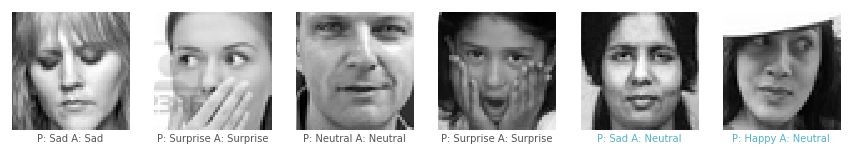

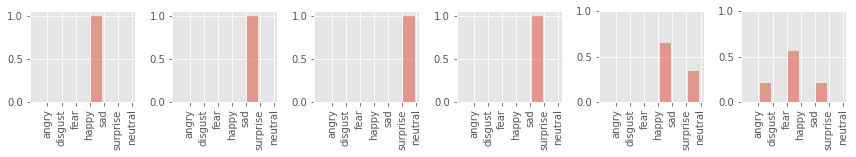

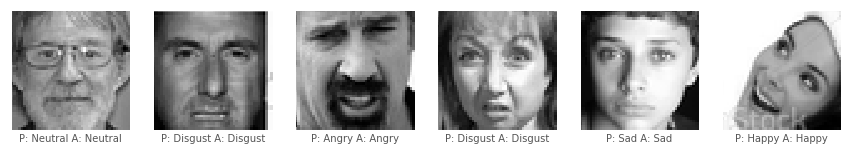

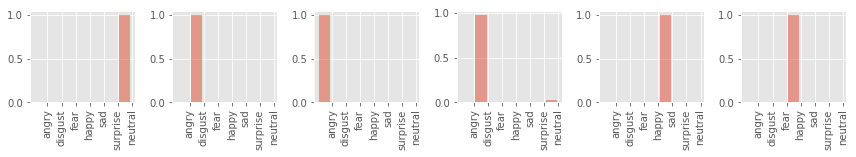

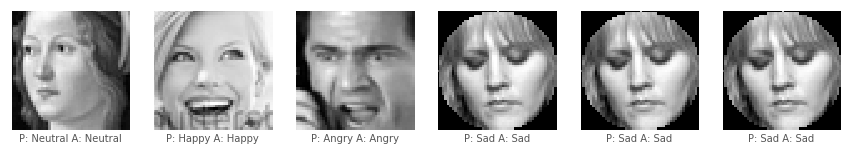

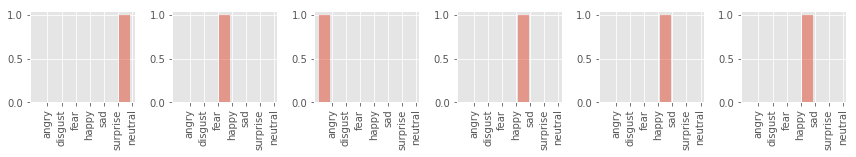

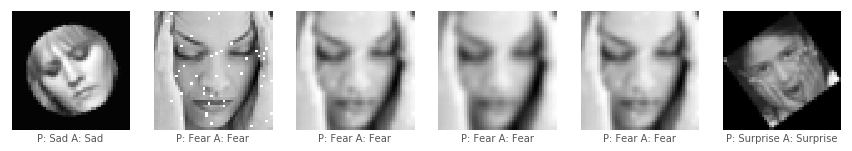

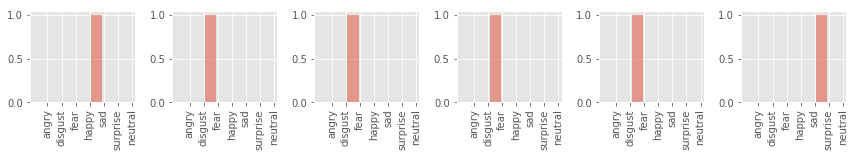

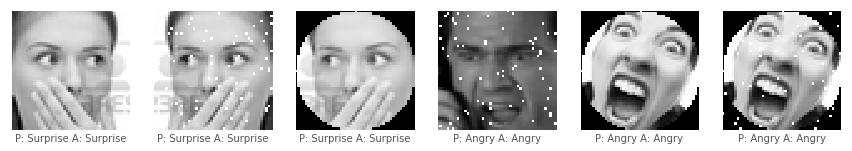

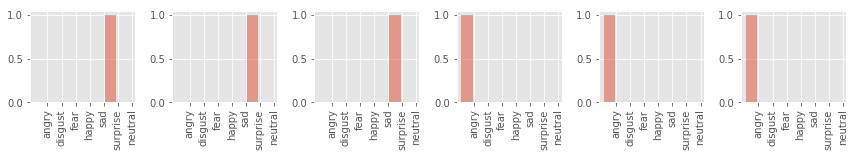

In [37]:
plot_subjects_with_probs(0, 36, y_prob)

# Plot the distribution of Predicted vs True

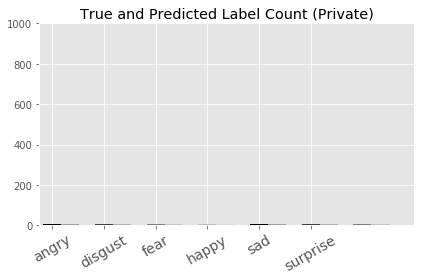

In [38]:
labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']
def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=('.00', '.25', '.50', '.75'), alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=('.00', '.25', '.50', '.75'), alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()

plot_distribution(y_true, y_pred)

# Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    print (cm)
    print(len(y_true))
    print(len(y_prob))
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[5 0 0 0 0 0 0]
 [0 5 0 0 0 0 1]
 [0 0 4 0 0 0 0]
 [0 0 0 4 0 1 0]
 [0 0 0 0 6 0 0]
 [0 0 0 0 0 6 0]
 [0 0 0 1 1 0 3]]
37
37


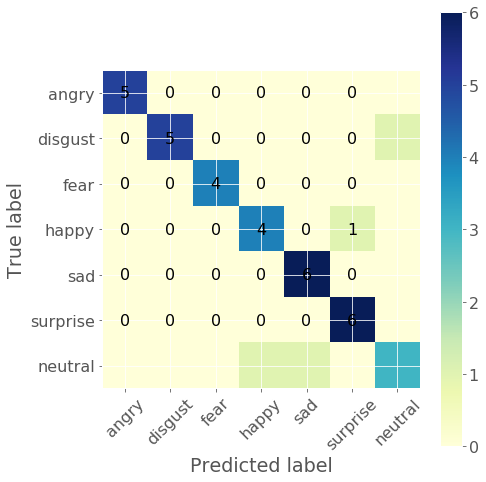

In [40]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

# Classification Matrix

In [41]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,len(labels))]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,len(labels))]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,7)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [42]:
# private test set
for emotion in labels:
    print(emotion.upper())
    print('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 1.0
  prec = 1.0
recall = 1.0

DISGUST
   acc = 1.0
  prec = 1.0
recall = 0.8333333333333334

FEAR
   acc = 1.0
  prec = 1.0
recall = 1.0

HAPPY
   acc = 0.9696969696969697
  prec = 0.8
recall = 0.8

SAD
   acc = 1.0
  prec = 0.8571428571428571
recall = 1.0

SURPRISE
   acc = 0.9696969696969697
  prec = 0.8571428571428571
recall = 1.0

NEUTRAL
   acc = 0.9090909090909091
  prec = 0.75
recall = 0.6



In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       1.00      1.00      1.00         5
    disgust       1.00      0.83      0.91         6
       fear       1.00      1.00      1.00         4
      happy       0.80      0.80      0.80         5
        sad       0.86      1.00      0.92         6
   surprise       0.86      1.00      0.92         6
    neutral       0.75      0.60      0.67         5

avg / total       0.89      0.89      0.89        37



# Visualize the Keras Layers

In [44]:
# https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer

from keras import backend as K

def layers_overview(images):
    total_rows = len(images)
    fig = plt.figure(figsize=(8,10))
    idx = 0
    for i, row in df.iterrows():
        input_img = img
        ax = fig.add_subplot(16,12,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
    plt.show()

def get_layer_outputs(img, use_dropout):
    test_image = img
    outputs    = [layer.output for layer in model.layers]          # all layer outputs
    comp_graph = [K.function([model.input]+ [K.learning_phase()], [output]) for output in outputs]  # evaluation functions

    # Testing
    dropout = 1 if use_dropout else 0
    layer_outputs_list = [op([test_image, dropout]) for op in comp_graph]
    layer_outputs = []

    for layer_output in layer_outputs_list:
        print(layer_output[0][0].shape, end='\n-------------------\n')
        layer_outputs.append(layer_output[0][0])

    return layer_outputs

def plot_layer_outputs(img, layer_number, use_dropout):    
    layer_outputs = get_layer_outputs(img, use_dropout)

    x_max = layer_outputs[layer_number].shape[0]
    y_max = layer_outputs[layer_number].shape[1]
    n     = layer_outputs[layer_number].shape[2]

    L = []
    for i in range(n):
        L.append(np.zeros((x_max, y_max)))

    for i in range(n):
        for x in range(x_max):
            for y in range(y_max):
                L[i][x][y] = layer_outputs[layer_number][x][y][i]


#     for img in L:
#         plt.figure(figsize=(2, 2))
#         plt.imshow(img, interpolation='nearest', cmap='gray')
    layers_overview(L)

In [ ]:
# test_img = [testData[0]]
plot_layer_outputs(np.array(test_img), 2, use_dropout=False)

# Detailed Analysis

In this work we have used the default architecture but instead of normal convolution we have used winograd convolution and the additional advantage of obtaining the accuracy is adding the random different kinds of image augementation and normalization of the data distribution due to which performance has increased from the state of the art 

# Future Scope

In this project as the next step would perform the following 
1.Change the architecture to take less params 
2.Train it on customized dataset(own dataset) and check its accuracy 
3.Train it for Japanese or Chinese people dataset and validate its accuracy and improve it 
4.Remove the FC and put 1x1 Convolution 

# Result Comparision

The results comparisionfrom the Kaggle competition have an accuracy of

Winograd Convolution-AbhilashSK-0.75000
RBM -Charlie Tang-0.71161
Unsupervised-Chetan Ramaiah-0.69267

